In [4]:
# IMPORT THE NECESSARY LIBRARIES
import pandas as pd
import re # This module provides functions for working with regular expressions allowing search, match and manipulate strings based on patterns
import os # This module allows interaction with the operating system, such as working with files, directories, environment variables, and system commands.
import sys # This module provides access to system-specific parameters, including command-line arguments (sys.argv), standard input/output, and exiting the program (sys.exit()).
import matplotlib.pyplot as plt
import scipy.optimize as opt
from matplotlib.ticker import MaxNLocator
from statsmodels.graphics.tsaplots import plot_acf # This function is used for plotting the Autocorrelation Function (ACF), which is helpful in time series analysis to measure how observations are correlated with their past values.
from mice_inspection_utils import * # Import all functions 
                                    # NOTICE: this is different from import mice_inspection_utils! In that case you'd have to use the module name as a prefic to access functions, classes or variables. E.g. mice_inspection_utils.some_function()
from scipy.stats import linregress
from glob import glob # Function that will later be used to find all files that match a pattern

# This part avoids possible conflict due to the structure of mice_inspection_utils
if not os.path.exists('Data/by_mouse'): 
    os.makedirs('Data/by_mouse')

# GET THE NECESSARY DATA
imput_subj_paths = [f"Data/raw/total.full.rn.RA.total_OTU_table.mouse{i+1}.ovr0.0p.csv" for i in range(0, 8)]
output_subj_paths = [f"Data/by_mouse/mouse_{i+1}.csv" for i in range(0, 8)]
metadata_path = "Data/raw/OTU_table.csv"
mi = Mice_Inspection(ip = imput_subj_paths, op = output_subj_paths, mdp = metadata_path)

# Population dynamics of bacteria in the gut microbiome: a data analysis

## Short description

The advancement in DNA sequencing tecniques have enabled access to fine-detailed information about the composition of gut microbiota. There is a widespread interest in the scientific comunity around the goal of modeling and predicting the dynamics of these ecological communities, with the aim of producing innovative terapeutic interventions.  However, althogh a wide variety of methods have been published in recent years, many of these are unprincipled and lack reliable validation methods.  Some studies suggest that gut microbiomes cluster into distinct groups (enterotypes), while others argue that these patterns may arise as artifacts of statistical analysis rather than biological reality. 


In our project, following the article *"A macroecological description of alternative stable states reproduces intra- and inter-host variability of gut microbiome", Silvia Zaoli and Jacopo Grilli*, we analyze experimental data of mice gut microbiota assuming a simple stochastic logistic model. This model, specifically, assumes that each bacterial species evolves independently from the others, thus it can be used as a simple, essential null-model to investigate if inter-species interactions can be at all inferred from the data.

The logistic model predicts that, after a transient, the species abundances will eventually settle down to a steady state, parametrized by two parametes: the carrying capacity, accounting for the global effect of the environment, and a parameter $\sigma$ quantifying the stochastic noise. We will follow the methods described in the article, which use a properly defined dissimilarity measure to assess stationarity, designed to overcome the scarsity of data samples.

This main task will require preliminary data processing and basic statistic analysis. 

!!!!   WE HAVEN'T DONE THIS YET !!!!
Optionally, in the case where the null model doesn't suffice to explain the data, we will try to infer the interaction matrix of species-species interaction assuming a simple stochastic Lockta Volterra model, and using linear regression with k-fold validation.

## 1. Preprocessing and sample composition analysis

**Data preprocessing**: 

group OTUs corresponding to same species, fix naming issues, double measures etc, retrieve total number of OTUs, total number of species, set up pandas DataFrames and OTU-species dictionary.

**Analysis of the cross-subject sample composition variability at different taxonomic-unit levels:** 

Biological organisms are classified in groups on the basis of similarity. Biologists refer to these groups as "taxonomic units" or taxa. Different taxa are also grouped together in a higher-level group ("taxon") based on commonly shared features, resulting in a nested hierarcical classification. The basic scheme of modern classification makes use of $8$ levels of classification, which are, from top to bottom: $\textit{Domain, Kindom, Phylum, Class, Order, Family, Genus, Species}$. 

The task is to assess the cross-subject variability of the sample composition at the various levels of the taxonomic classification. The output will be given in the form of stacked-bar plots.

**Rank Abundance Distribution (RAD):**
    
The frequency of each species is computed (= #counts_species/ #counts sample) . Species are ranked with an integer index from the most frequent (i= 1) to the least frequent (i= N). The curve displaying the frequency versus the rank (so-called rank-abundance distribution, or RAD) is experimentally known to assume a lognormal or power-law -like shape, with the first few species occupying the majority of the sample, and a long tail of rare species contributing to the remaining part.

In [5]:
## THE ABOVE PART SHOULD BE REVISITED DEPENDING ON WHAT MIRIAM ACTUALLY WANTS TO TALK ABOUT
## OTHERWISE WE STILL NEED TO MODIFY THE ABOVE TEXT BUT WE CAN SIMPLY PRESENT THE DATA ANALISYS AND FUNCTIONS
## THAT ARE USED FROM MICE_INSPECT LATER

## 2. Theoretical models



#### Deterministic Logistic Model

The deterministic logistic model represents the growth of a population, or in this case the abundance $\lambda$ of a microbial species, constrained by the enviroment. 
The equation for DLM is: $$\dot{\lambda} = \frac{1}{\tau}\lambda \left(1-\frac{\lambda}{K}\right)  $$

This model has two parameters:
* K: the carrying capacity, it is the maximum population size that an enviroment can sustain, given the available resources.
* $\tau$: ralxation time, it is related to the growth rate of the population and determines the time scale of relaxation to stationarity.

1. When $\lambda$ is small, growth is nearly exponential.
2. When $\lambda$ gets close to K, growth slows.
3. When $\lambda=K$, growth stops as $\dot{\lambda}=0$ 



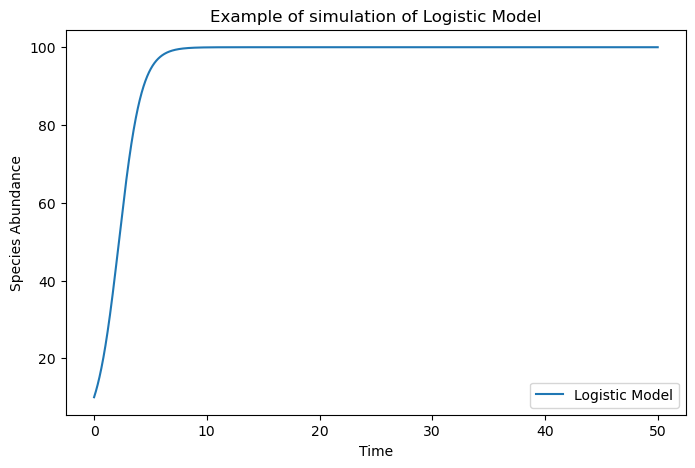

In [6]:
# DEFINE THE LOGISTIC MODEL FUNCTION

def LM(ab0, K, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that species of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]
        ab_vals[t] = ab + (ab/tau)*(1 - (ab / K)) * dt[t-1]
        # Prevent numerical issues
        ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
    return ab_vals

# Random trial just to visualize the function

# Parameters
ab0 = 10   # Initial population size
K = 100    # Carrying capacity
sigma = 0.1  # Noise intensity
tau = 1.0  # Characteristic time scale
steps = 5000  # Number of steps
dt = np.asarray([0.01]*steps)  # Time step

# Run simulation
ab_vals = LM(ab0, K, tau, steps, dt)

# Plot results
time_vals = np.linspace(0, steps * dt[0], steps + 1)
plt.figure(figsize=(8, 5))
plt.plot(time_vals, ab_vals, label="Logistic Model")
plt.xlabel("Time")
plt.ylabel("Species Abundance")
plt.title("Example of simulation of Logistic Model")
plt.legend()
plt.show()

#### Stochastic logistic model

The stochastic version of the model introduces some randomness due to enviromental fluctuatons by adding a noise term, which better reflects real-world variability:
$$\dot{\lambda} = \frac{1}{\tau}\lambda \left(1-\frac{\lambda}{K}\right)  + \lambda \sqrt{\frac{\sigma}{\tau}}\xi(t) $$
where $\xi(t)$ is the Gaussian white noise.

This model has three parameters: 
* K, $\tau$ previously described.
* $\sigma$: it measures the intensity of the enviromental noise. 

The SLM does not include interaction among species and therefore cannot reproduce patterns of interspecies correlation. However, it correctly reproduces several patterns of the dynamics of a single species, including fluctuations and possible extinction events in small populations.

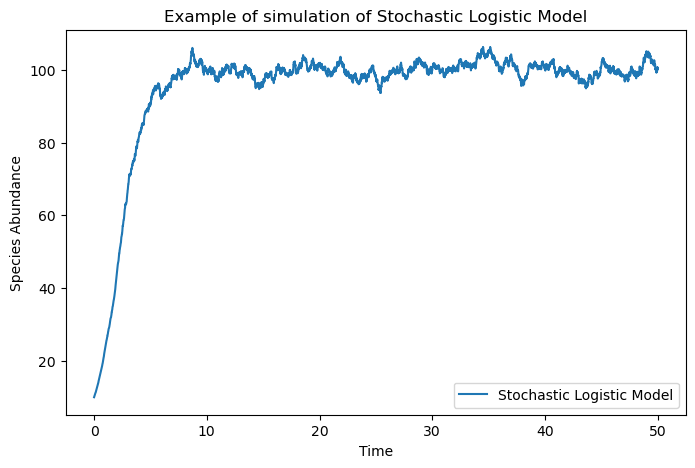

In [7]:
# Define the function to simulate a stochastic logistic model

def simulate_SLM(ab0, K, sigma, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that species of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]
        ab_vals[t] = ab + ( (ab/tau)*(1 - (ab / K)) +  ab * np.sqrt(sigma/tau) * np.random.normal() ) * dt[t-1]
        # Prevent numerical issues
        #ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
        ab_vals[t] = max(0, ab_vals[t])
    return ab_vals

# Random trial just to visualize the function

# Parameters
ab0 = 10   # Initial population size
K = 100    # Carrying capacity
sigma = 0.1  # Noise intensity
tau = 1.0  # Characteristic time scale
steps = 5000  # Number of steps
dt = np.asarray([0.01]*steps)  # Time step

# Run simulation
ab_vals = simulate_SLM(ab0, K, sigma, tau, steps, dt)

# Plot results
time_vals = np.linspace(0, steps * dt[0], steps + 1)
plt.figure(figsize=(8, 5))
plt.plot(time_vals, ab_vals, label="Stochastic Logistic Model")
plt.xlabel("Time")
plt.ylabel("Species Abundance")
plt.title("Example of simulation of Stochastic Logistic Model")
plt.legend()
plt.show() 

#### Lotka-Volterra model --> !!! TO TAKE OFF SINCE NOT DONE

The Lotka-volterra model extends population dynamics by incorporating interactions between species, such as competition or mutualism. 


## 3. Basic time-series analysis

Say $\vec{X}(t) =\left[x_1(t), x_2(t), \cdots x_N(t)\right]$ is the abudance of the first N most abudant species at time t. We model $\vec{X}(t)$ as a stochastic process, for which
each subject $\vec{X}(t)$ represents a different sample path.

* Visualization:

    Plot time-series for each mouse and for each species to visualize the evolution in time

The basic analysis to perform is:

* Compute the time dependent mean and variance $\mathbb{E}[\vec{X}(t)],\, \mathbb{E}[\vec{X}^2(t)]$. Plot as a summary the time evolution for the mean +- std of each species
* Correlations: filter the most abundant species upon a certain threshold and compute their covariance matrix 
* Autocorrelation: compute the autocorrelation function $\mathbb{E}[x(t) \cdot x(s)]$

In [8]:
## ALSO THIS IS MIRIAM'S FIELD ##

In [9]:
## JUST AS A COPY OF WHAT THERE IS IN LOGISTICMODEL.IPYNB

### Data Structure

In [10]:
# By calling mice_df we have the dataframes for each mouse
df = mi.mice_df[0]
df.head() # -> As we can see we have the bacterial species, the median, the mean counts, and the counts per day (at day 1, 8, 9 ...)

,Unnamed: 0,species,median_counts,mean_counts,1,8,9,10,15,17,...,1001,1004,1010,1016,1022,1028,1029,1035,1039,1044
0,0,Prevotella sp. Smarlab 121567,412.0,415.156682,0,0,0,2,10,18,...,220,248,252,286,346,293,277,190,222,364
1,1,Parabacteroides distasonis,205.5,206.709677,0,0,0,2,41,145,...,136,157,206,133,177,105,163,147,208,222
2,3,Barnesiella intestinihominis,142.0,145.419355,0,0,0,1,19,58,...,158,145,184,131,145,154,119,130,71,161
3,4,Barnesiella viscericola,125.5,137.092166,0,1,0,1,112,195,...,66,85,134,96,126,121,92,71,72,147
4,2,Lactobacillus taiwanensis,123.5,174.769585,0,422,309,0,48,15,...,36,162,282,174,100,306,517,193,513,175


In [11]:
# By calling get_species_df
df = mi.get_species_df(species = 'Prevotella sp. Smarlab 121567')
df.head(10) # -> As we can see we have the count per day of the selected species in each mouse

,day,mouse_1,mouse_2,mouse_3,mouse_4,mouse_5,mouse_6,mouse_7,mouse_8,mean,std
0,0,0,1,0,0,0,0,0,2,0.375,0.744024
1,1,0,0,0,0,0,0,0,1,0.125,0.353553
2,2,0,1,1,0,0,0,0,2,0.500,0.755929
3,3,0,0,0,0,2,0,0,0,0.250,0.707107
4,4,0,0,0,0,0,0,0,0,0.000,0.000000
5,5,0,0,0,0,0,0,0,0,0.000,0.000000
6,6,0,0,0,0,0,0,0,0,0.000,0.000000
7,7,0,0,0,0,0,0,0,0,0.000,0.000000
8,8,0,0,0,0,0,0,0,7,0.875,2.474874
9,9,0,0,9,0,1,60,0,0,8.750,20.940392


## 4. Stochastic Logistic Model

Here we follow the main reference *"A macroecological description of alternative stable states reproduces intra- and inter-host variability of gut microbiome", Silvia Zaoli and Jacopo Grilli*.

### Dissimilarity

Calculate data **dissimilarity** defined as $$\Phi_i(t,T)=\left(\frac{\lambda_i(t)-\lambda_i(t+T)}{\lambda_i(t)+\lambda_i(t+T)}\right)^2$$where $\lambda_i(t)$ is the relative frequency of the species $i-th$ at time $t$, and $T$ is the log.
Distinguish OTUs that have stationary dynamics from the others, visualize in a plot $\Phi_i(T)/\Phi_i^\infty$ vs T.  Discriminate between stationary and non-stationary abundancies (perform a linear fit, set a threshold and discriminate slopes above/below threshold).

    

In [12]:
# create the dataframes with the dissimilarity values for each mouse

mice_diss = []
oracle_file = os.path.join(os.getcwd(), "Data" ,"dissimilarities")  # Construct the path Data/dissimilarities in the current working directory (cwd)
                                                                    # "oracle" because is a source of truth or knowledge (folder that if exists, that's what we get data from)

if not os.path.exists(oracle_file): # If the folder does not exist, compute and store dissimilarities
    for mouse in range(1,9): 
        df = mi.get_dissimilarities(mouse, write = True)
        mice_diss.append(df)
    print("Database created")
else: # If the file exists, load precomputed dissimilarities
    for mouse in range(1,9): 
        folder_path = os.path.join(oracle_file, f"dissimilarity_{mouse}.csv")
        csv_files = glob(folder_path)  # Get all CSV file in folder (in general glob finds all files that match a pattern)
        df_list = [pd.read_csv(file,index_col=0)  for file in csv_files]   # Read and merge all files
        mice_diss.append(pd.concat(df_list,ignore_index=False))
        
    print("Data take from files; if you want to compute again delete folder")

Data take from files; if you want to compute again delete folder


In [13]:
# Check that it was built correctly considering for example the first mouse
mice_diss[0].head()

,1,2,3,4,5,6,7,8,9,10,...,1027,1028,1029,1030,1031,1034,1035,1036,1038,1043
Prevotella sp. Smarlab 121567,0.152198,0.171746,0.062899,0.094635,0.111559,0.100248,0.159679,0.158560,0.198151,0.141593,...,0.940133,1.0,0.930256,1.000000,1.000000,0.989131,1.000000,1.000000,1.0,1.0
Parabacteroides distasonis,0.063016,0.084766,0.051827,0.052748,0.085593,0.070336,0.085282,0.074986,0.091216,0.080886,...,0.681340,1.0,0.717952,1.000000,1.000000,0.982302,1.000000,1.000000,1.0,1.0
Barnesiella intestinihominis,0.137988,0.090815,0.087523,0.109374,0.123000,0.083900,0.144142,0.103052,0.126055,0.137472,...,0.740400,1.0,0.783781,1.000000,1.000000,0.987731,1.000000,1.000000,1.0,1.0
Barnesiella viscericola,0.160086,0.079281,0.060972,0.120502,0.157528,0.097143,0.143658,0.096437,0.122690,0.106828,...,0.654971,1.0,0.482109,1.000000,0.945956,0.986578,1.000000,0.973156,1.0,1.0
Lactobacillus taiwanensis,0.378027,0.294579,0.240163,0.315811,0.377685,0.302834,0.428027,0.476685,0.378278,0.271188,...,0.615931,1.0,0.662169,0.061591,0.009472,1.000000,0.076651,0.171177,1.0,1.0


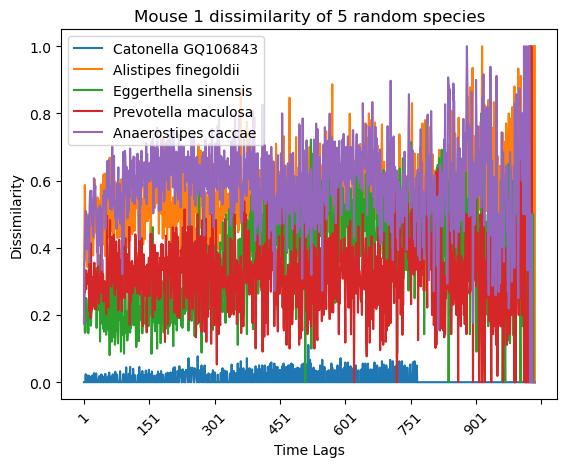

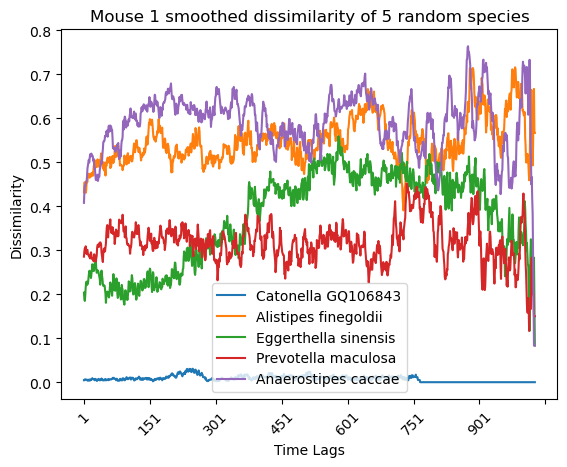

In [14]:
# EXAMPLE For the first mice
species = np.asarray(mice_diss[0].index)
n_species = 5
rnd_idx = np.random.choice(np.arange(len(species)), n_species)
species = species[rnd_idx]
lags = np.asarray(mice_diss[0].columns)

for sp in species: 
    data = mice_diss[0].loc[sp].values
    plt.plot(lags, data, label = sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.title('Mouse 1 dissimilarity of 5 random species')
plt.xlabel('Time Lags')
plt.ylabel('Dissimilarity')
plt.legend()
plt.show()

# Let's smooth the data a bit for better visualization
def moving_average(data, window_size=5): #This means that for each point t, we take the average of the previous W points.
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

for sp in species: 
    data = mice_diss[0].loc[sp].values
    smoothed_data = moving_average(data, window_size=10)
    plt.plot(lags[:len(smoothed_data)], smoothed_data, label=sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.title('Mouse 1 smoothed dissimilarity of 5 random species')
plt.xlabel('Time Lags')
plt.ylabel('Dissimilarity')
plt.legend()
plt.show()   


In [15]:
#This function does the operations above for all mice and saves plots in pdf
plot_dissimilarities_in_pdf(mice_diss, n_species_per_plot=5, window_size=10, ma = True)

PDF files already exist in Inspection_Outputs\dissimilarityplots. Delete directory Inspection_Outputs\dissimilarityplots to regenerate plots.


### Stationarity:

- Discriminate between stationary and non-stationary abundancies (perform a linear fit, set a threshold and discriminate slopes above/below threshold). 
To do so, we:
    1. Perform a linear fit on data dissimilarities and save slopes, for each mouse and species
    2. Set a threshold to classify if data dissimilarity is increasing or flat, corresponding to a non-stationary or stationary species for a specific mouse


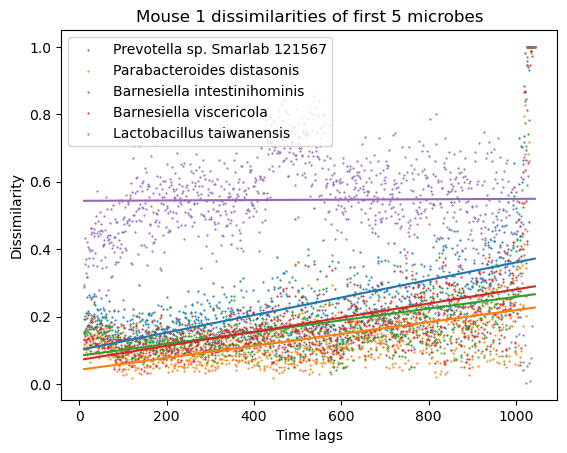

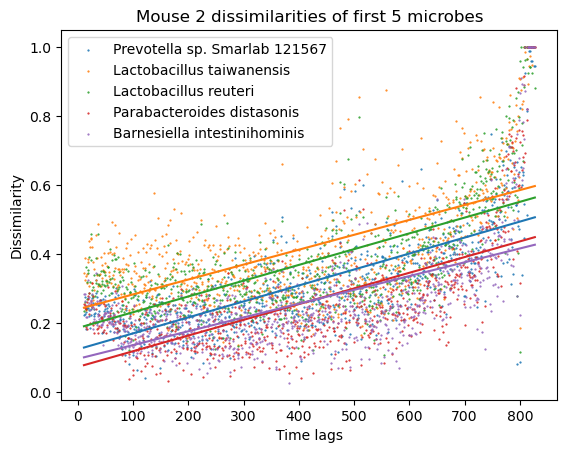

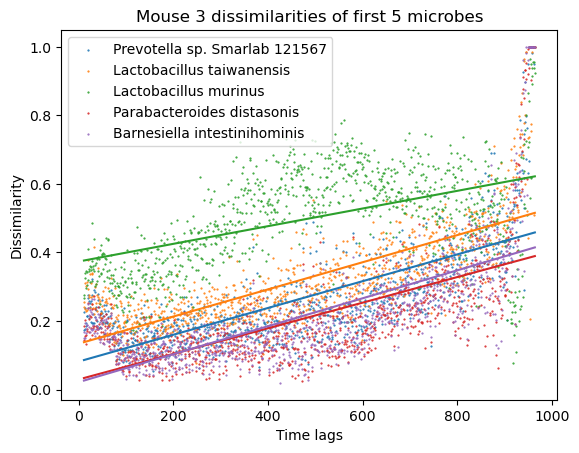

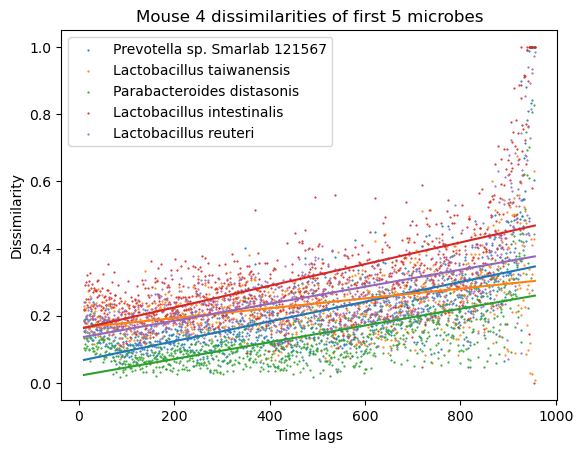

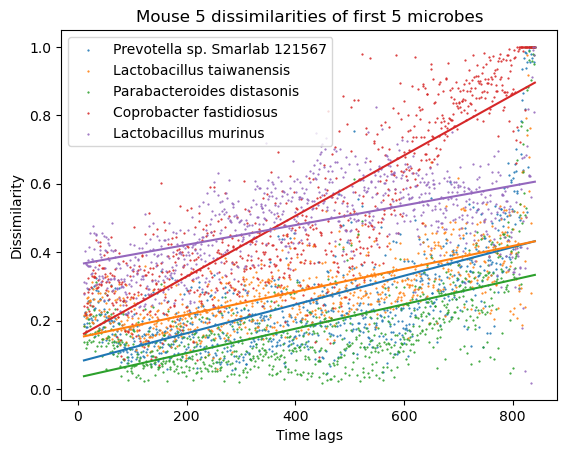

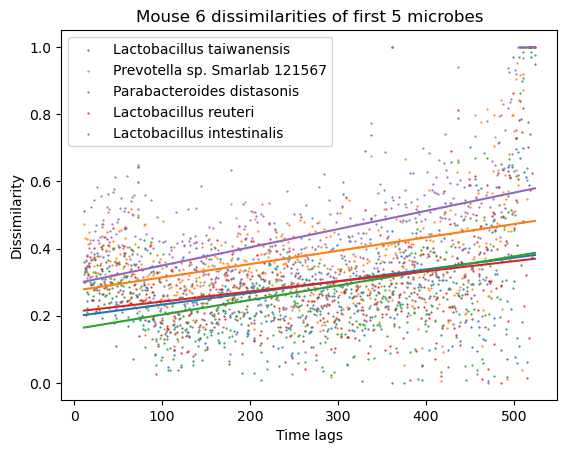

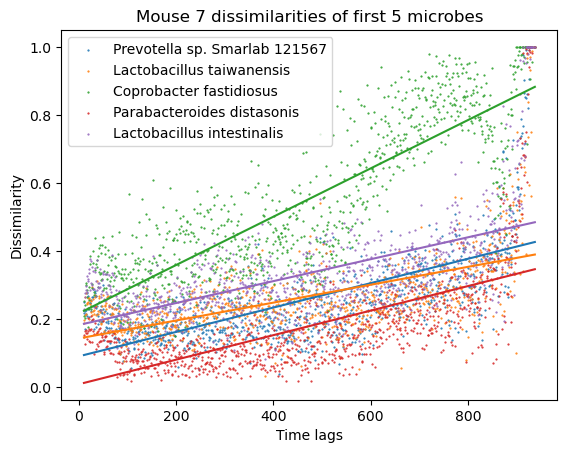

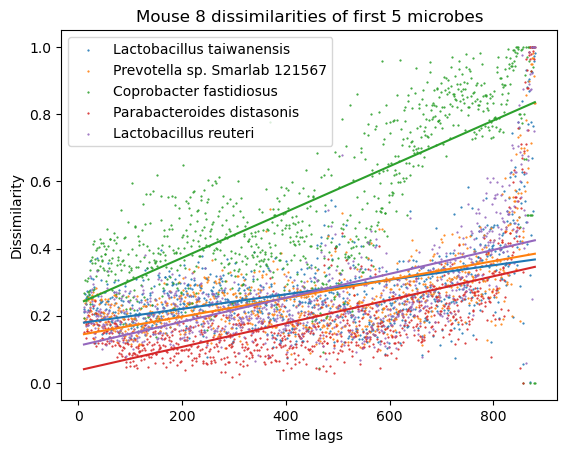

In [16]:
# Discard the initial transient (T > 10) 
for idx, mouse_df in enumerate(mice_diss): 
    mice_diss[idx] = mouse_df.drop(mouse_df.columns[:10], axis=1)

# Perform a linear fit EXAMPLE for first 5 species for each mouse
for idx, mouse_df in enumerate(mice_diss): 
    data = mouse_df.head(5)
    sp_m = []
    sp_q = []
    sp_pred = []
    for sp_idx in range(len(data)): 
        sp_data = np.asarray(data.iloc[sp_idx, :])
        lags = np.asarray(data.columns, dtype = int)
        m, q, *_ = linregress(lags, sp_data)
        pred_data = m*lags + q
        sp_m.append(m)
        sp_q.append(q)
        sp_pred.append(pred_data)
        plt.scatter(lags, sp_data, s = 0.3, label = f'{mouse_df.index[sp_idx]}')
        plt.plot(lags, pred_data)
        plt.xlabel("Time lags")
        plt.ylabel("Dissimilarity")
    plt.title(f"Mouse {idx + 1} dissimilarities of first 5 microbes")
    plt.legend()
    plt.show()


In [17]:
#This function does the operations above for all species for each mouse and saves plots in pdf
plot_dissfit_in_pdf(mice_diss, n_species_per_plot=5)

PDF files already exist in Inspection_Outputs\dissimilarityfit. Delete directory Inspection_Outputs\dissimilarityfit to regenerate plots.


From the article: 
"To establish the threshold, we accounted for the fact that, although we
expect a flat dissimilarity if the abundance is stationary, a slope different from zero can be found because of the noise in the estimation of $\Phi$, which depends on the length and density of the time series, on the
sequencing depth, and from the OTU parameters. Therefore, for each individual, we computed the threshold as follows:

1.  We simulated the dynamics of each OTU according to the SLM with parameters equal to the parameters estimated for that OTU and $\tau$ = 1. 

2. From these time series of $\vec{\lambda}$, we sampled the time series of $\vec{x}$ according to the sampling depth of the corresponding samples in the data, obtaining therefore values of $\vec{x}$ only for days for which the individual was sampled. 

3. We then computed $\tilde{\Phi}_i(T)$ and its slope for each
OTU. We defined as threshold for an individual the 95% quantile of
the slopes obtained for that individual, i.e., the value such that only
5% of slopes obtained from the simulation are larger." 


In practical, to set the threshold we :
1. Fit data abundancies into a LM (could be also a SLM, but computationally expensive and not necessary for next steps; better LM because easier to identify when stationarity is reached), in order to obtain K and tau optimized parameters
2. Simulate artificial data following LM using optimized parameters
3. From simulated data, identify transient to stationarity and discard it from real data (we are doing a sort of masking to keep only stationary abundances)
4. From stationary abundancies estimate parameters with the theoretical values (from article): $\langle \lambda \rangle = K \frac{2 - \sigma}{\sigma}$, $\text{var}(\lambda) = \frac{\langle \lambda \rangle^2}{2 - \sigma}$
5. Sample simulated data on effective measurement days. From sampled simulated data compute simulated dissimilarity $\tilde{\Phi}_i(T)$ and its slope for each species. Set threshold fot each mouse the 95% quantile of the slopes obtained for that individual; classificate dissimilarity as increasing or flat.



In [18]:
# 0. PREPARE DATA FOR THE FIT: data cleaning from the columns that do not correspond to species names or abundancies
mice_ab = []
for mouse_num in range(len(mi.mice_df)): 
    columns = mi.mice_df[mouse_num].columns
    mice_ab.append(mi.mice_df[mouse_num].drop(columns = ['Unnamed: 0', 'median_counts', 'mean_counts']))

In [19]:
# 1. FIT TO GET THE VALUE OF K, TAU -> EXAMPLE FIRST MOUSE FIRST SPECIES

df = mice_ab[0]         # Load the first mouse's data
species = df['species']
ts_data = df.iloc[0, 1:].to_numpy()
nonzero = np.nonzero(ts_data)[0]
start_idx = nonzero[0] + 1  # Adjust for skipped species column if needed
time_series = df.iloc[0, start_idx:].to_numpy()  # Extract the first species' time series
days = np.asarray(df.columns[start_idx:], dtype=int)  # Get measurement days
dt = np.diff(days)  # Compute time intervals

# Objective function for optimization
def objective(params, time_series, dt):
    K, tau = params
    simulated_data = LM(
        ab0=time_series[0], K=K, tau=tau, steps=len(time_series)-1, dt=dt
    )
    
    if np.isnan(simulated_data).any():  # Check for NaN values
        return np.inf  # Return a large penalty value
    
    return np.sum((simulated_data - time_series)**2)  # Minimize MSE

# Define parameter bounds
bounds_K = (1, 1e3) 
bounds_tau = (0.5, 5.5)  
bounds = [bounds_K, bounds_tau]

# Fit : Use Differential Evolution for Global Search -> able to fit also SLM
result = opt.differential_evolution(objective, bounds, args=(time_series, dt), strategy='best1bin')

K_opt, tau_opt = result.x
print(f"Estimated K: {K_opt}")
print(f"Estimated tau: {tau_opt}")


Estimated K: 444.16002722735374
Estimated tau: 2.8312492851915416


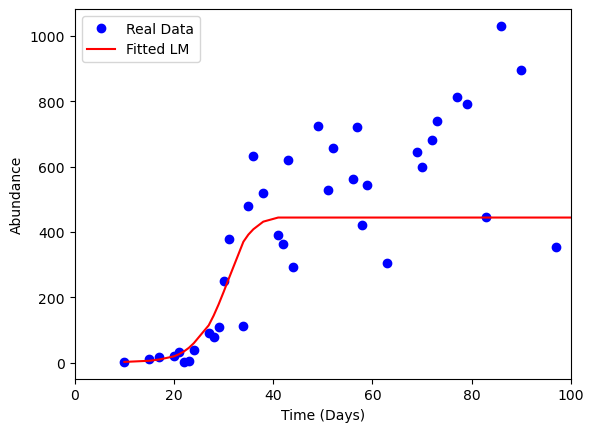

In [20]:
# 2. SIMULATE DATA USING REFINED PARAMETERS -> EXAMPLE FIRST MOUSE FIRST SPECIES
fitted_data = LM(
    ab0=time_series[0], K=K_opt, tau=tau_opt, steps=len(time_series)-1, dt=dt
)

# Plot real vs fitted data
plt.plot(days, time_series, 'bo', label="Real Data")
plt.plot(days, fitted_data, 'r-', label="Fitted LM")
plt.xlabel("Time (Days)")
plt.ylabel("Abundance")
plt.xlim(0,100) 
plt.legend()
plt.show()

In [21]:
# 3. GET RID OF TRANSIENT -> EXAMPLE FIRST MOUSE FIRST SPECIE
def find_transient_end(time_series, window_size=10, threshold=0.01):
    variances = [np.var(time_series[i-window_size:i]) for i in range(window_size, len(time_series))]
    changes = np.abs(np.diff(variances))  # Change in variance, if small we reached stationarity 
    for idx, change in enumerate(changes):
        if change < threshold:
            return idx + window_size  # Adjust index due to slicing
    return 0  # If no stable region is found, return 0 (keep all data)


# Discard the transient phase from the time series
transient_end_idx = find_transient_end(fitted_data)  
time_series_red = time_series[transient_end_idx:]
days_red=days[transient_end_idx:]


In [22]:
# 4. ESTIMATE THE VALUES OF K AND SIGMA FROM THEORY -- > EXAMPLE FIRST MOUSE FIRST SPECIE
var=np.var(time_series_red)
mean=np.mean(time_series_red)

sigma_th=2*var/(mean**2+var)
K_th=mean*2/(2-sigma_th)

print("Theoretical K:", K_th)
print("Theoretical sigma:", sigma_th)

Theoretical K: 522.7782979601894
Theoretical sigma: 0.32433748030850906


In [23]:
# AUTOMATICALLY DO THE PREVIOUS OPERATIONS (1->4) FOR ALL MICE AND SPECIES

def lm_objective(params, time_series, dt):
    K, tau = params
    simulated_data = LM(ab0=time_series[0], K=K, tau=tau, steps=len(time_series)-1, dt=dt)   
    if np.isnan(simulated_data).any():  
        return np.inf  # Large penalty value   
    return np.sum((simulated_data - time_series)**2)  # Minimize MSE

def find_transient_end(time_series, window_size=10, threshold=0.01):
    variances = [np.var(time_series[i-window_size:i]) for i in range(window_size, len(time_series))]
    changes = np.abs(np.diff(variances))  # Change in variance, if small we reached stationarity   
    for idx, change in enumerate(changes):
        if change < threshold:
            return idx + window_size  # Adjust index due to slicing
    return 0  # If no stable region is found, return 0 (keep all data)

# Define parameter bounds
bounds_K = (1, 1e3)  
bounds_tau = (0.5, 5.5)  
bounds = [bounds_K, bounds_tau]

K_df, tau_df, sigma_df = params_to_csv(mi, mice_ab, objective, bounds, LM, find_transient_end, force_recompute=False)

PDF files already exist in Inspection_Outputs\LMfits. Delete directory Inspection_Outputs\LMfits to regenerate plots.
Loaded K, sigma, tau dataframes from csv files.


In [24]:
# DEFINE THE FUNCTIONS TO COMPUTE DISSIMILARITY AND THRESHOLD 
def dissimilarity(simulated_series):
        dissimilarity_data=[]
        days=np.arange(0,len(simulated_series),1)
        valid_day_pairs = {T: {day for day in days if (day + T) in days} for T in range(1, len(simulated_series) + 1)}

# For each species, compute dissimilarities by time lag
        for T in range(1, len(simulated_series) + 1):
                total_diss = 0
                count = 0
                for day in valid_day_pairs[T]:
                    diss_t = ((simulated_series[day] - simulated_series[day + T]) / 
                            max(1, (simulated_series[day] + simulated_series[day + T])))**2
                    total_diss += diss_t
                    count += 1

                # Only store dissimilarities for time lags with valid days
                if count > 0:
                    dissimilarity_data.append(total_diss / count)

        return dissimilarity_data 

def threshold(start, K_df, sigma_df, df, mouse_num):
    """
    Compute the threshold based on simulated species dissimilarity.
    
    Args:
    - start: Starting abundance index for each species.
    - K_df: DataFrame of carrying capacities (species x mice).
    - sigma_df: DataFrame of sigma values (species x mice).
    - df: Abundance DataFrame (species x time points).
    - mouse_num: Integer indicating which mouse's data to process.
    
    Returns:
    - threshold_value: 95th percentile of dissimilarity slopes.
    """
    slopes, sim_serie_diss = [], []

    species_list = df.index  # Get species names

    # for species in species_list: 
    for spidx, species in enumerate(species_list): 
        measurement_days = np.asarray(df.columns[start[spidx]:], dtype=int)
        start_day = int(df.columns[start[spidx]])

        # Extract K and sigma values for this species & mouse
        K_val = K_df.loc[species, f"Mouse {mouse_num+1}"]
        sigma_val = sigma_df.loc[species, f"Mouse {mouse_num+1}"]

        # Simulate data with theoretical K and sigma
        time_steps = 0.1
        steps = len(measurement_days) * 10 *5  # Total simulation steps
        dt = np.full(steps, time_steps)      
        simulated_series = simulate_SLM(
            ab0=start[spidx],  
            K=K_val,
            sigma=sigma_val,
            tau=1.0,  
            steps=steps,
            dt=dt
        )
        
        # Extract simulated values for real measurement days
        nsteps_per_day = int(1 / time_steps)
        indexes_to_extract = np.clip((measurement_days - start_day) * nsteps_per_day, 0, len(simulated_series) - 1)
        simulated_series_sampled = simulated_series[indexes_to_extract]

        # Plot simulation results only for first species
        if species == species_list[0]:
            time_vals = np.linspace(start_day, steps * time_steps, steps + 1)
            plt.plot(time_vals, simulated_series, label="Stochastic Logistic Model")
            plt.scatter(measurement_days, simulated_series_sampled, color="red", s=20, label="Extracted days")
            plt.xlabel("Time")
            plt.ylabel("Species Abundance")
            plt.title(f"Simulated SLM sampled as {species} in mouse {mouse_num+1}")
            plt.legend()
            plt.show()

        # Compute dissimilarity and extract threshold
        simulated_series_diss = dissimilarity(simulated_series_sampled)
        sim_serie_diss.append(simulated_series_diss)

        if species == species_list[0]:  # Plot only for the first species
            plt.scatter(np.arange(len(simulated_series_diss)), simulated_series_diss)
            plt.title(f"Simulated dissimilarity as {species} in mouse {mouse_num+1}")
            plt.ylabel('Dissimilarity')
            plt.xlabel('Time lags')
            plt.show()

        slope, _, _, _, _ = linregress(np.arange(len(simulated_series_diss)), simulated_series_diss)
        slopes.append(abs(slope))  # Ensure positive slopes

    #threshold_value = np.percentile(slopes, 95)  # 95th percentile as threshold
    threshold_value = np.percentile(slopes, 85)  # 95th percentile as threshold
    return threshold_value


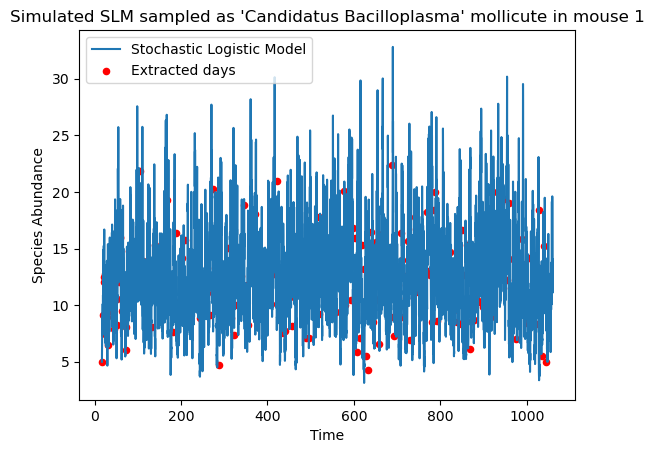

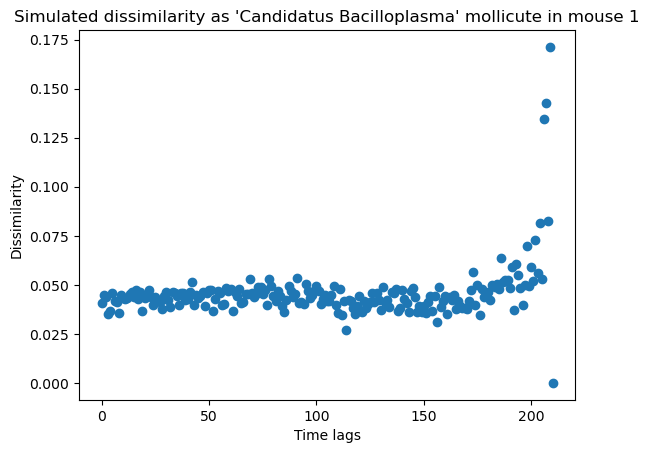

Processing Mouse 1, obtained threshold: 0.0005784160546058014
Trends for Mouse 1 appended to dataframe


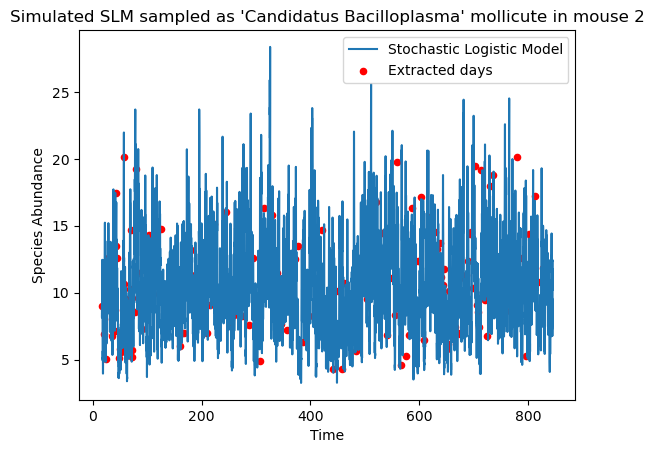

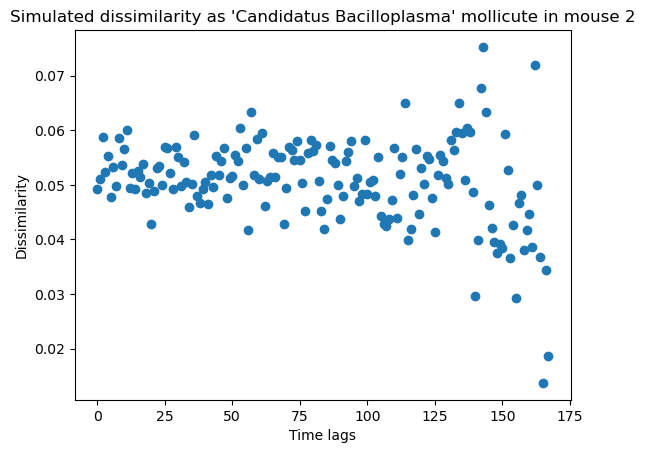

Processing Mouse 2, obtained threshold: 0.0006934991291693644
Trends for Mouse 2 appended to dataframe


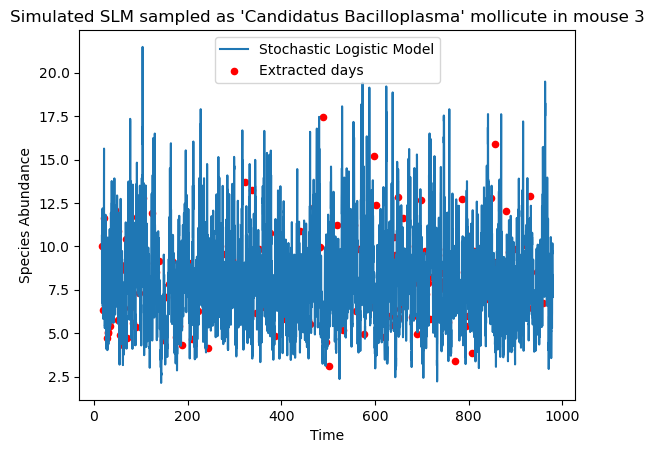

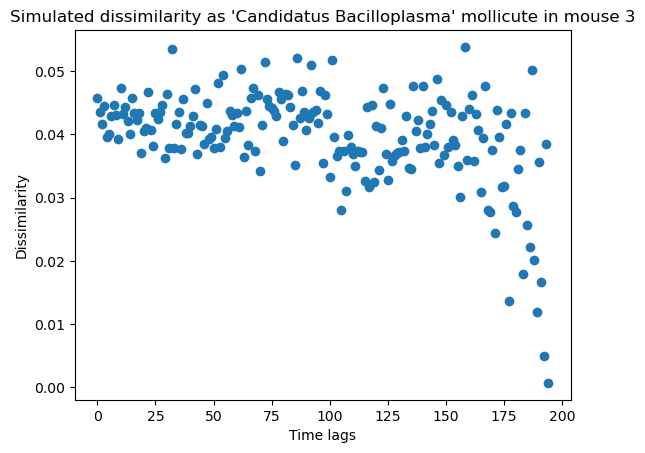

Processing Mouse 3, obtained threshold: 0.0006660678971173083
Trends for Mouse 3 appended to dataframe


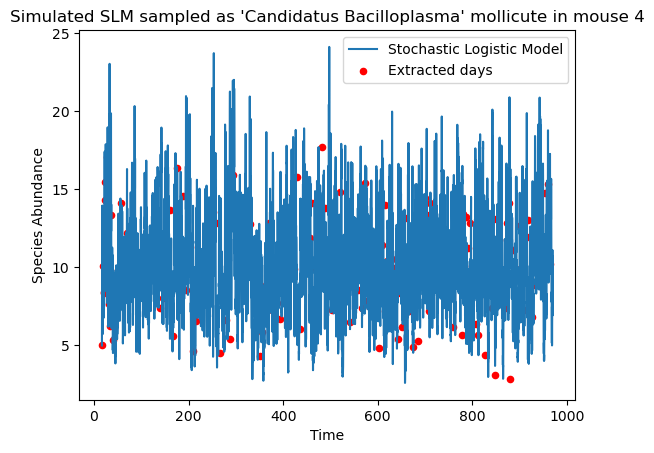

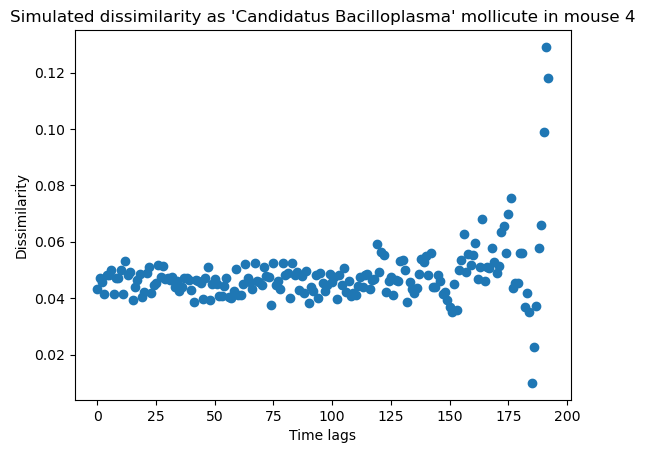

Processing Mouse 4, obtained threshold: 0.0006547516670881272
Trends for Mouse 4 appended to dataframe


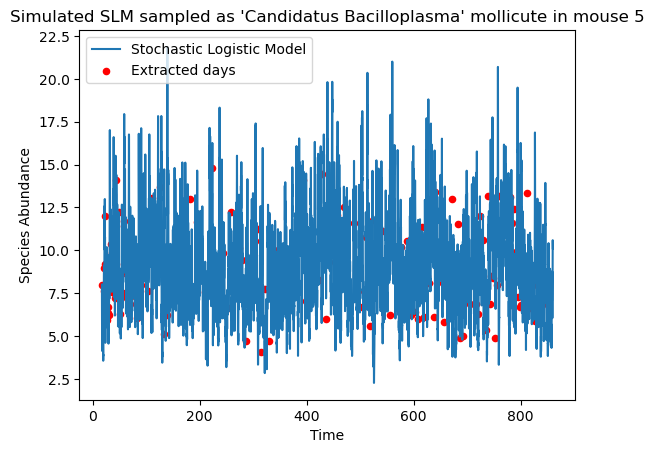

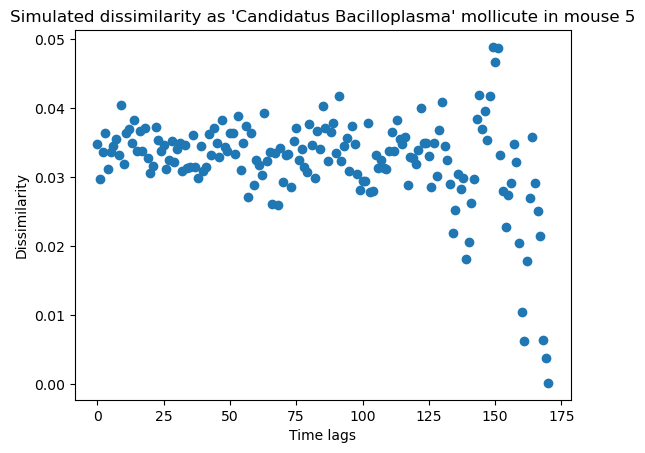

Processing Mouse 5, obtained threshold: 0.0006704889069170235
Trends for Mouse 5 appended to dataframe


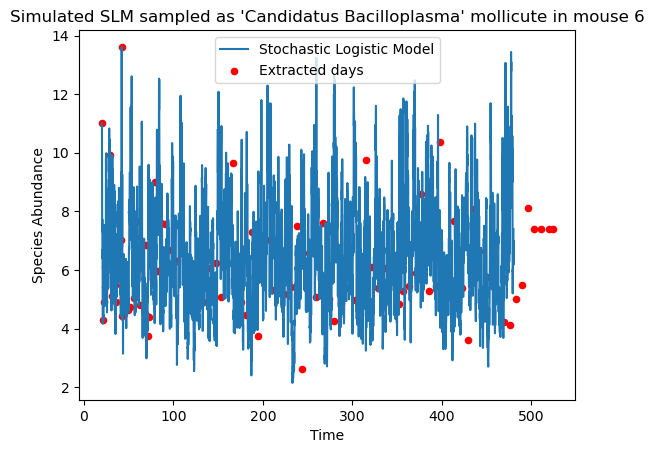

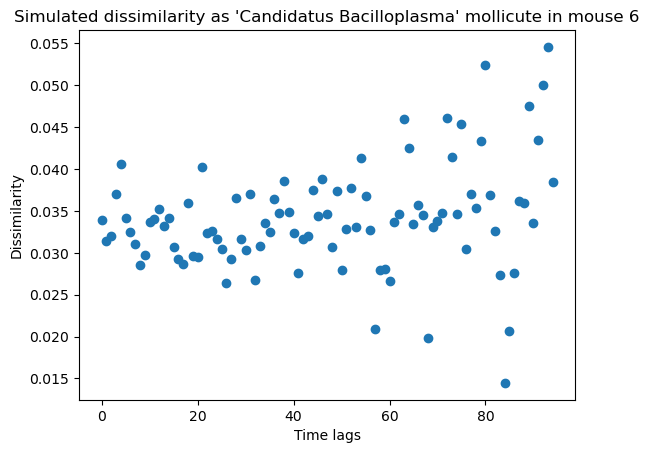

c:\Users\angel\anaconda3\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
c:\Users\angel\anaconda3\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\angel\anaconda3\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Processing Mouse 6, obtained threshold: nan
Trends for Mouse 6 appended to dataframe


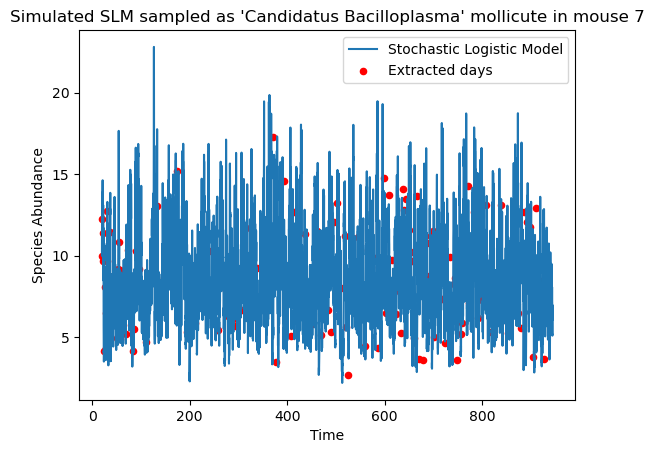

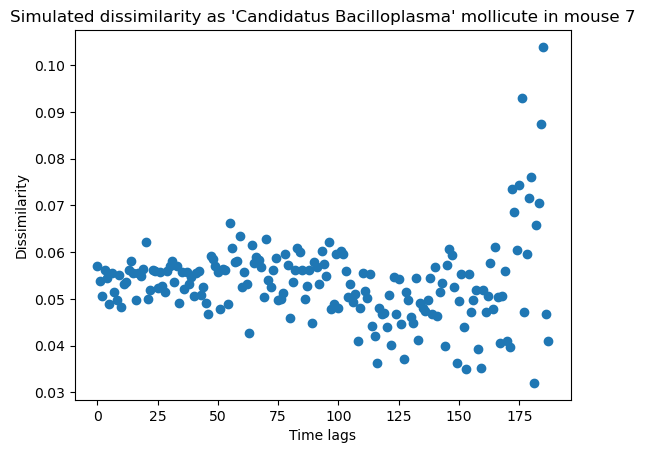

Processing Mouse 7, obtained threshold: 0.000747475515132277
Trends for Mouse 7 appended to dataframe


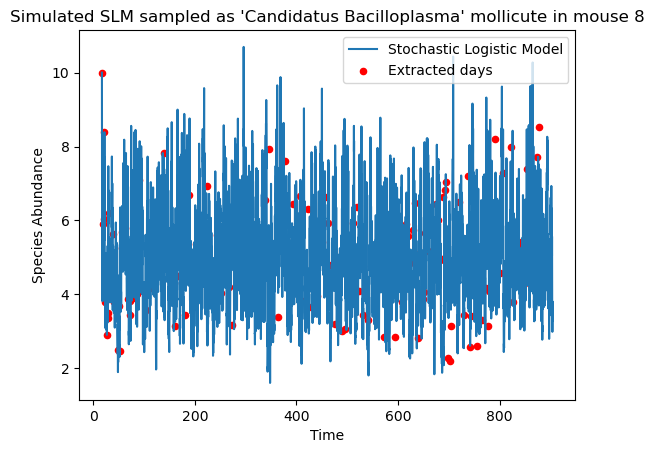

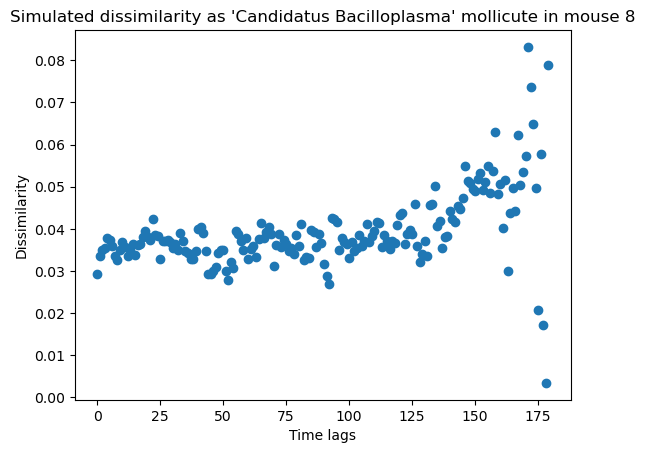

Processing Mouse 8, obtained threshold: 0.0008884978241526481
Trends for Mouse 8 appended to dataframe


In [25]:
# 5. Sample simulated data, compute simulated dissimilarities, set threshold --> DOING THIS DIRECTLY FOR ALL MICE AND SPECIES

# Filter parameter and data dataframes in order to have species as indexes with same order
mask= np.any(K_df.isna(),axis=1)    
K_filtered = K_df[~mask]
sigma_filtered = sigma_df[~mask]

K_filtered=K_filtered.set_index('Unnamed: 0', drop=True)
sigma_filtered=sigma_filtered.set_index('Unnamed: 0', drop=True)

summary_df = []
for mouse_idx, mouse in enumerate(mice_diss):

    df = mi.mice_df[mouse_idx] 
    df.index=df['species']
    species_in_both = df.index.intersection(K_filtered.index)
    species_in_both=species_in_both.sort_values() 
    df_filtered = df.loc[species_in_both]
    K_filtered = K_filtered.loc[species_in_both]
    sigma_filtered = sigma_filtered.loc[species_in_both]
 
    # Extract abundance data (excluding metadata columns)
    abundance_data = df_filtered.iloc[:, 4:].to_numpy()

    # Find species with at least one nonzero abundance at any time point
    nonzero_species = np.any(abundance_data > 0, axis=1)  # Fix: Now checks for any nonzero value

    if np.sum(nonzero_species) == 0:  # No species with nonzero values
        print(f"Skipping Mouse {mouse_idx + 1} (no nonzero species)")
        summary_df.append(pd.DataFrame())  # Append empty DataFrame for consistency
        continue  

    # For each species, find the index of the first nonzero time point.
    first_nonzero_idx = np.where(nonzero_species, np.argmax(abundance_data > 0, axis = 1), -1)
    first_nonzero_idx = np.clip(first_nonzero_idx, 0, abundance_data.shape[1] - 1) # Ensure indices are within the valid range

    # Compute the threshold for the current mouse
    threshold_mouse = threshold(
        start = first_nonzero_idx,
        K_df=K_filtered,  # Pass K values
        sigma_df=sigma_filtered,  # Pass sigma values
        df=df_filtered.iloc[:, 4:],  # Pass only the abundance data
        mouse_num=mouse_idx
    )

    print(f"Processing Mouse {mouse_idx + 1}, obtained threshold: {threshold_mouse}")

    # Store trends for each species
    trend = []

    # Iterate over species in the mouse dataset
    for spec_idx, spec in enumerate(df_filtered.index):  
        time_diss = mouse.loc[spec]

        # Compute the slope using linear regression
        slope_mouse, _, _, _, _ = linregress(np.arange(len(time_diss)), time_diss)

        # Determine the trend based on threshold
        trend.append("incr" if slope_mouse > threshold_mouse else "flat")

    #Compute theoretical stationary dissimilarity value
    diss_inf_values = sigma_filtered[f"Mouse {mouse_idx + 1}"] / (4 - sigma_filtered[f"Mouse {mouse_idx + 1}"])

    temp_df = pd.DataFrame({
        'TREND': trend,
        'K': K_filtered[f"Mouse {mouse_idx + 1}"].values.flatten(),
        'sigma': sigma_filtered[f"Mouse {mouse_idx + 1}"].values.flatten(),
        'diss_inf': diss_inf_values.values.flatten()
    }, index=species_in_both)

    # Append to summary DataFrame
    summary_df.append(temp_df)

    # Append trend classification to the DataFrame
    mouse.loc[species_in_both]["TREND"] = trend


    print(f"Trends for Mouse {mouse_idx + 1} appended to dataframe")


* Distinguish OTUs that have stationary dynamics from the others, visualize in a plot $\Phi_i(T)/\Phi_i^\infty$ vs T, where the theoretical expectation value for the dissimilarity at stationarity is $\mathbb{E}[\Phi_i^\infty]=\frac{\sigma}{4-\sigma}$

In [26]:
normalized_diss_list=[]

for mouse_idx in range(len(mice_diss)):
    selected_species=summary_df[mouse_idx].index
    selected_diss=mice_diss[mouse_idx].loc[selected_species]
    normalized_diss = selected_diss.div(summary_df[mouse_idx]['diss_inf'], axis=0)  # Element-wise division

    normalized_diss_list.append(normalized_diss)  # Store for this mouse

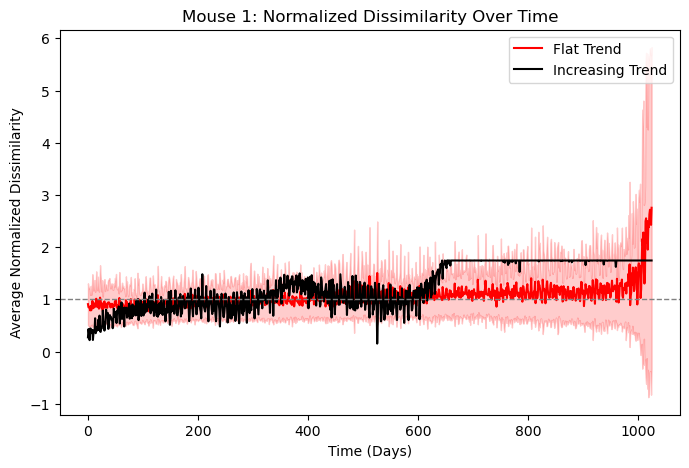

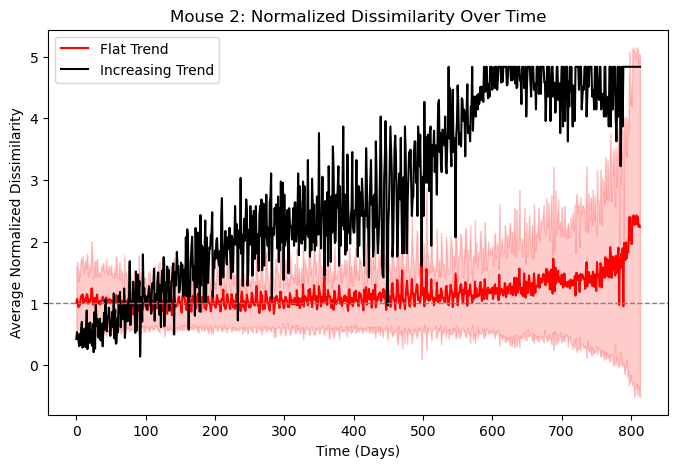

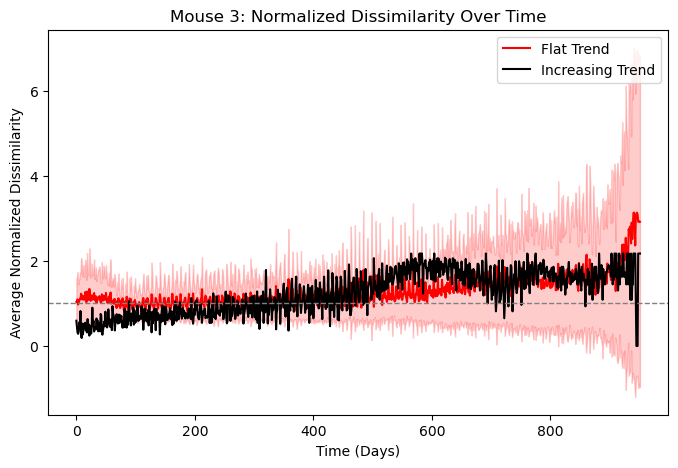

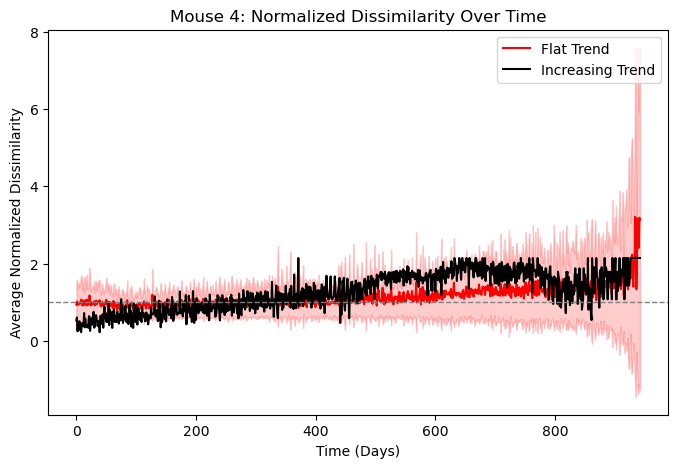

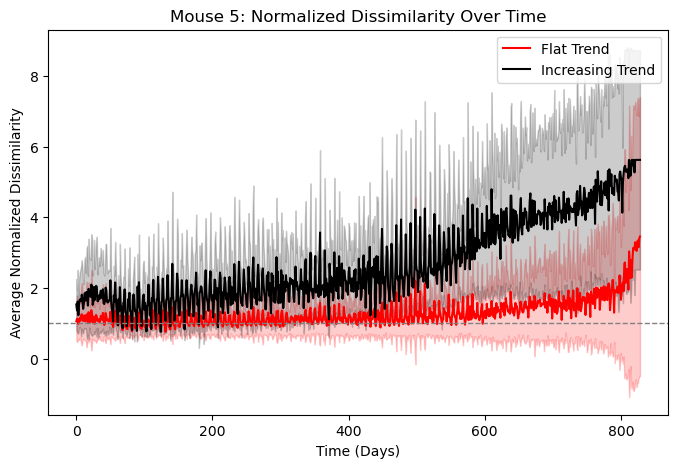

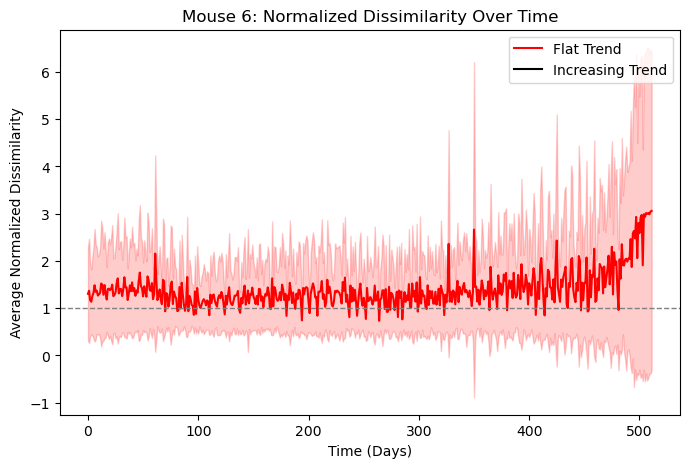

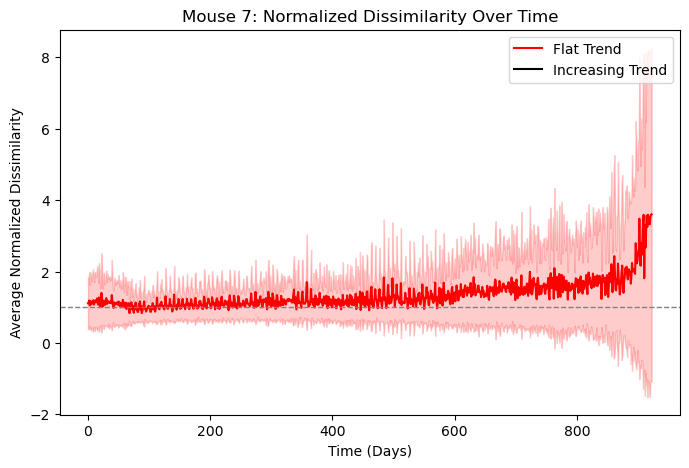

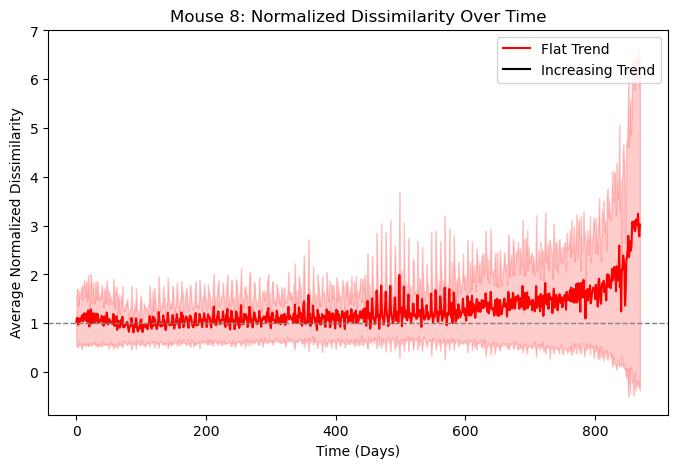

In [28]:
# Iterate through each mouse
flat_list=[]
incr_list=[]

for mouse_idx in range(len(mice_diss)):
    if summary_df[mouse_idx].empty or normalized_diss_list[mouse_idx].empty:
        print(f"Skipping Mouse {mouse_idx + 1} (empty data)")
        continue

    # Select species based on TREND
    flat_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'flat'].index
    incr_species = summary_df[mouse_idx][summary_df[mouse_idx]['TREND'] == 'incr'].index

    flat_list.append(flat_species)
    incr_list.append(incr_species)

    # Compute mean and standard deviation across species for each trend
    mean_diss_flat = normalized_diss_list[mouse_idx].loc[flat_species].mean(axis=0)  
    std_diss_flat = normalized_diss_list[mouse_idx].loc[flat_species].std(axis=0)

    mean_diss_incr = normalized_diss_list[mouse_idx].loc[incr_species].mean(axis=0)  
    std_diss_incr = normalized_diss_list[mouse_idx].loc[incr_species].std(axis=0)

    # X-axis: time points
    time_points = np.arange(len(mean_diss_flat))

    # Create a new figure for each mouse
    plt.figure(figsize=(8, 5))

    # Plot mean dissimilarities
    plt.plot(time_points, mean_diss_flat, linestyle='-', color='red', label='Flat Trend')
    plt.plot(time_points, mean_diss_incr, linestyle='-', color='black', label='Increasing Trend')

    # Add shaded region (Mean ± SD)
    plt.fill_between(time_points, mean_diss_flat - std_diss_flat, mean_diss_flat + std_diss_flat, color='red', alpha=0.2)
    plt.fill_between(time_points, mean_diss_incr - std_diss_incr, mean_diss_incr + std_diss_incr, color='black', alpha=0.2)

    # Add a horizontal dashed line at y = 1
    plt.axhline(y=1, color='gray', linestyle='dashed', linewidth=1)

    # Labels and title
    plt.xlabel("Time (Days)")
    plt.ylabel("Average Normalized Dissimilarity")
    plt.title(f"Mouse {mouse_idx + 1}: Normalized Dissimilarity Over Time")
    plt.legend()

    # Show plot for this mouse
    plt.show()


* Perform a taxonomic analysis on species with nonstationary behaviour (common classifications or something else)

In [ ]:
#### PER LUCA: 
# flat_list[mouse_num] è la lista delle specie flat per il topo a mouse_num
# incr_list idem 


SOMEBODY WANTS TO DO IT???

 if $\sigma<2$, the stationary distribution is gamma $$P(\lambda; K, \sigma) = \frac{1}{\Gamma (2/\sigma -1)} \left(\frac{2}{\sigma K}\right)^{2/\sigma -1} \lambda^{2/\sigma-2} e^{-\frac{2}{\sigma K}\lambda} $$
 so we can produce a histogram out of our data and superimpose the theoretical pdf; perform test on distribution

SOMEBODY WANTS TO DO IT?

### (optional) Lotka-Volterra

(optional): apply some Lokta Volterra model to non-stationary species